<a href="https://colab.research.google.com/github/croco22/CapstoneProjectTDS/blob/philipp/notebooks/Dashboard_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extra Task 3: Live Demo

## Imports and Setup

In [1]:
%%capture
!pip install gradio
# !pip install git+https://github.com/openai/whisper.git
!pip install SpeechRecognition
!pip install qrcode[pil]

import io
import os
import logging
import sys
import time
import re
import requests
from datetime import datetime

import pandas as pd
import qrcode
# import whisper
import speech_recognition as sr
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import gradio as gr
import google.generativeai as genai
from IPython.display import display, Image
from google.colab import userdata


recognizer = sr.Recognizer()
logging.basicConfig(level=logging.ERROR)

# API Setup
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel('gemini-2.0-flash-exp')
userdata.get('HF_TOKEN')

# Download favicon
image_url = "https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/philipp/images/profile.jpg" # Todo: Set to main branch
img_data = requests.get(image_url).content
with open('favicon.png', 'wb') as handler:
    handler.write(img_data)


def generate_text(prompt):
    try:
        response = model.generate_content(
            prompt,
            generation_config = genai.GenerationConfig(
                temperature=2.0,
            )
        )
        time.sleep(5) # Avoid exceeding API limits
        return response.text.strip()
    except Exception as e:
        exit("Error during API call: ", e)

## Load data from the provided questionnaires

In [2]:
dfs = list()

for q in range(1, 6):
    url = f'https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/questionnaires/questionnaire{q}.json'
    temp_df = pd.read_json(url)

    # Unpack options into an array
    temp_df['options'] = temp_df['options'].apply(lambda x: [option['option'] for option in x])

    # Remove options for specific question types
    # because irrelevant or do not contribute meaningfully to the dataset
    temp_df.loc[temp_df['type'].isin(['TEXT', 'NUMBER', 'DATE']), 'options'] = None

    temp_df['questionnaire'] = f"Questionnaire {q}"

    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

## Rephrase questions if necessary

In [3]:
def rephrase_question(text):
    prompt = f"""
        Reformulate the following statement into a clear, concise, and
        grammatically correct question that directly addresses the user. For
        example, 'Do you consent to data processing?' or 'What kind of follow-up
        would you prefer?'. If the text is already a question, preserve its
        meaning and intent without altering the content or facts. The statement
        is: '{text}'. Return only the reformulated question, without any
        additional explanations, comments, or text.
    """
    return generate_text(prompt)


df['rephrased_question'] = df['question'].apply(rephrase_question)

df = df[['questionnaire', 'type', 'rephrased_question', 'options']].copy()
df['answer'] = "<skipped by user>"
df['missed_count'] = 0

df.head()

,questionnaire,type,rephrased_question,options,answer,missed_count
0,Questionnaire 1,SINGLE_SELECT,Do you consent to data processing?,"[Yes, No]",<skipped by user>,0
1,Questionnaire 1,SINGLE_SELECT,Which customer group are you referring to?,"[End User, Wholesaler, Distributor, Consultant...",<skipped by user>,0
2,Questionnaire 1,MULTI_SELECT,What products are you interested in?,"[MY-SYSTEM, Notion, JTS, JS EcoLine, AKW100, A...",<skipped by user>,0
3,Questionnaire 1,MULTI_SELECT,What kind of follow-up is planned?,"[Email, Phone, Schedule a Visit, No action]",<skipped by user>,0
4,Questionnaire 1,MULTI_SELECT,Who should be copied in the follow-up?,"[Stephan Maier, Joachim Wagner, Erik Schneider...",<skipped by user>,0


## Evaluate context
The code selects the most relevant question from a list based on a combination of semantic similarity (using embeddings) and contextual relevance (using a question-answering model).

In [4]:
# qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
# def evaluate_context(context, unanswered_questions):
#     best_question = None
#     highest_score = -1
#     context_embedding = embedding_model.encode([context])

#     for question in unanswered_questions:
#         qa_result = qa_pipeline(question=question, context=context)
#         score = qa_result['score']

#         question_embedding = embedding_model.encode([question])
#         similarity = cosine_similarity(context_embedding, question_embedding)[0][0]

#         combined_score = score * similarity

#         if combined_score > highest_score:
#             highest_score = combined_score
#             best_question = question

#     return best_question


# # def evaluate_answer(message, options):
# #     message_embedding = embedding_model.encode([message])

# #     highest_similarity = -1
# #     best_answer = None

# #     for option in options:
# #         option_embedding = embedding_model.encode([option])
# #         similarity = cosine_similarity([message_embedding[0]], [option_embedding[0]])[0][0]

# #         if similarity > highest_similarity:
# #             highest_similarity = similarity
# #             best_answer = option

# #     return best_answer

In [74]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
# classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")

def get_number(text):
    prompt = f"""
        Following text contains a phone number: '{text}'.
        Extract the phone number and only return the phone number, without any
        additional explanations, comments, or text.
    """
    return generate_text(prompt)


def get_date(text):
    prompt = f"""
        Following text contains a date/time reference: '{text}'.
        Extract the date and convert it into the format DD.MM.YYYY. If it
        contains a reference like 'in two weeks', take the current date and
        return the calculated date based on this. Return the date without any
        additional explanations, comments, or text.
    """
    return generate_text(prompt)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
    self._run_once()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in 

In [88]:
def evaluate_context(context, questions, qtype=None):
    if qtype is None or qtype == "SINGLE_SELECT": # Clustering for qtype=None --> multi_label=True
        question_results = classifier(context, candidate_labels=questions)
        best_match = question_results["labels"][0]
        return best_match
    elif qtype == "MULTI_SELECT":
        question_results = classifier(context, candidate_labels=questions, multi_label=True)
        best_matches = [
            label for label, score in zip(question_results["labels"], question_results["scores"])
            if score > 0.25
        ]
        return ", ".join(map(str, best_matches))
    elif qtype == "TEXT":
        return context
    elif qtype == "NUMBER":
        return get_number(context)
    elif qtype == "DATE":
        return get_date(context)
    else:
        return "[ERROR] Evaluation not possible"

## Gradio application

In [94]:
def evaluate_message(message, unanswered_questions, df_v):
    if isinstance(unanswered_questions, gr.State):
        uq_list = unanswered_questions.value
    else:
        uq_list = unanswered_questions

    real_question = evaluate_context(message, uq_list)
    # for q in real_questions:
    answer_options = df_v[df_v['rephrased_question'] == real_question]['options'].iloc[0]
    qtype = df_v[df_v['rephrased_question'] == real_question]['type'].iloc[0]
    df_v.loc[df_v['rephrased_question'] == real_question, 'answer'] = evaluate_context(message, answer_options, qtype)

    real_idx = uq_list.index(real_question)
    df_v.loc[(df_v['rephrased_question'].isin(uq_list[:real_idx])), 'missed_count'] += 1

    uq_list.remove(real_question)

    remaining_uq_list = [question for question in uq_list if df_v[df_v['rephrased_question'] == question]['missed_count'].iloc[0] <= 1]

    return remaining_uq_list, df_v


def set_response(unanswered_questions, df_v=None):
    if isinstance(unanswered_questions, gr.State):
        uq_list = unanswered_questions.value
    else:
        uq_list = unanswered_questions

    if len(uq_list) == 0:
            return "Thank you! Please submit your responses via 'Send' :)"

    flag = False
    if df_v is None:
        unanswered_questions_string = '<ol style="font-size: 13px;">' + ''.join([f'<li>{q}</li>' for q in uq_list]) + '</ol>'
        response = f"""
            <p>Please answer the following questions:</p>
            <p>{unanswered_questions_string}</p>
        """
    else:
        unanswered_questions_string = '<ol style="font-size: 13px;">'
        for q in uq_list:
            missed_count_row = df_v[df_v['rephrased_question'] == q]
            missed_count = missed_count_row['missed_count'].iloc[0]
            if missed_count == 1:
                flag = True
                unanswered_questions_string += f'<li style="color: #77f7d1;">{q}</li>'
            else:
                unanswered_questions_string += f'<li>{q}</li>'

    unanswered_questions_string += '</ol>'
    if flag:
        response = f"""
            <p>Please answer the following questions<span style='color: #77f7d1;'>*</span>:</p>
            <p>{unanswered_questions_string}</p>
            <p style='color: #77f7d1; font-size: 10px;'>* Highlighted questions will be skipped if unanswered.</p>
        """
    else:
        response = f"""
            <p>Please answer the following questions:</p>
            <p>{unanswered_questions_string}</p>
        """

    return response

In [95]:
def start_chat(selected_questionnaire, history):
    q = df[df['questionnaire'] == selected_questionnaire]['rephrased_question'].tolist()
    history.append({"role": "assistant", "content": set_response(q)})
    return (
        gr.update(visible=False),
        gr.update(visible=False),
        gr.update(value=history, visible=True),
        gr.update(visible=True),
        gr.update(visible=True),
        gr.State(q)
    )


def add_message(history, message, unanswered_questions, df_state):
    if isinstance(df_state, gr.State):
        df_v = df_state.value
    else:
        df_v = df_state

    if len(message["files"]) > 0:
        # model_turbo = whisper.load_model("turbo")
        # result = model_turbo.transcribe(message["files"][0])
        # message = result["text"]
        with sr.AudioFile(message["files"][0]) as source:
            audio_data = recognizer.record(source)
        try:
            message = recognizer.recognize_google(audio_data)
        except sr.UnknownValueError:
            exit("Audio could not be understood")
        except sr.RequestError as e:
            exit(f"Error with the request: {e}")
    elif message["text"] is not None and message["text"] != "":
        message = message["text"]
    else:
        message = "<auto> I'm a retailer."

    history.append({"role": "user", "content": message})
    uq_list, df_new = evaluate_message(message, unanswered_questions, df_v) # TODO: EIGENTLICH IN BOT BESSER
    if len(uq_list) == 0:
        return history, gr.update(visible=False), gr.State([]), gr.State(df_new)
    else:
        return history, gr.MultimodalTextbox(value=None), gr.State(uq_list), gr.State(df_new)


def bot(history, unanswered_questions, df_state):
    if isinstance(df_state, gr.State):
        df_v = df_state.value
    else:
        df_v = df_state

    response = set_response(unanswered_questions, df_v)
    history.append({"role": "assistant", "content": ""})
    for character in response: # Cool writing effect
        history[-1]["content"] += character
        time.sleep(0.007)
        yield history


def download(selected_questionnaire, df_state):
    if isinstance(df_state, gr.State):
        df_v = df_state.value
    else:
        df_v = df_state

    current_timestamp = datetime.now()
    formatted_timestamp = current_timestamp.strftime("%Y%m%d_%H%M%S")
    filename = f"answers_{formatted_timestamp}.json"

    filtered_df = df_v[df_v['questionnaire'] == selected_questionnaire]
    filtered_df = filtered_df[['rephrased_question', 'answer']].rename(columns={"rephrased_question": "question"})
    filtered_df.to_json(filename, orient='records', indent=4)

    return filename


def reset_state(original_df_state):
    return (
        gr.update(visible=True),
        gr.update(visible=True),
        gr.update(value=list(), visible=False),
        gr.update(value=dict(), visible=False),
        gr.update(visible=False),
        gr.State([]),
        original_df_state
    )

In [101]:
custom_css = """
.gradio-container {
  padding-left: 20% !important;
  padding-right: 20% !important;
}
"""

In [102]:
with gr.Blocks(theme='Nymbo/Nymbo_Theme', title="Philipp's Chatbot", css=custom_css) as app:
    gr.Markdown("""
        # Questionnaire Chatbot 👨‍💻🚀
        ### by Philipp Landeck
        <br>
    """)

    unanswered_questions = gr.State(value=[])
    df_state = gr.State(value=df)
    original_df_state = gr.State(value=df)

    dropdown = gr.Dropdown(
        choices=list(df['questionnaire'].unique()),
        # multiselect=True,
        label="Choose a questionnaire",
        interactive=True,
        visible=True,
        value=df['questionnaire'].iloc[0]
    )

    start_button = gr.Button("Start", visible=True)

    chatbot = gr.Chatbot(
        show_label=False,
        type="messages",
        visible=False,
        height=500
    )

    chat_input = gr.MultimodalTextbox(
        interactive=True,
        sources=['microphone'],
        placeholder="Enter message or record voice...",
        show_label=False,
        autofocus=True,
        visible=False
    )

    # Call download() function
    send_button = gr.DownloadButton("Send", value=download, visible=False, inputs=[dropdown, df_state])

    # Call start_chat() function
    start_button.click(
        start_chat, [dropdown, chatbot], [dropdown, start_button, chatbot, chat_input, send_button, unanswered_questions]
    )

    # Call add_message() function
    chat_msg = chat_input.submit(
        add_message, [chatbot, chat_input, unanswered_questions, df_state], [chatbot, chat_input, unanswered_questions, df_state]
    )

    # Call bot() function
    chat_msg.then(bot, [chatbot, unanswered_questions, df_state], chatbot)

    # Call reset_state() function
    send_button.click(
        reset_state, [original_df_state], [dropdown, start_button, chatbot, chat_input, send_button, unanswered_questions, df_state]
    )

## Start app and generate QR-Code

In [103]:
def generate_qr_code(url):
    qr = qrcode.QRCode(version=1, box_size=10, border=2)
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill='black', back_color='white')
    img_path = 'gradio_code.png'
    img.save(img_path)
    return img_path

Public URL (click to open the app): https://3a99a1fab508f20669.gradio.live



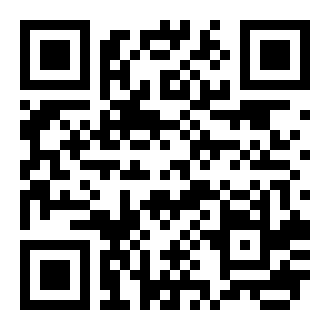

In [104]:
# Workaround to get the public URL
original_stdout = sys.stdout

output = io.StringIO()
sys.stdout = output # set print to output variable

app.launch(share=True, show_api=False, inline=False, favicon_path='/content/favicon.png')

sys.stdout = original_stdout # reset print to stdout

captured_output = output.getvalue()

link_pattern = r'(https://.*\.gradio\.live)'
re_match = re.search(link_pattern, captured_output)

if re_match:
    public_url = re_match.group(1)
    print(f"Public URL (click to open the app): {public_url}\n")
    qr_image_path = generate_qr_code(public_url)
    display(Image(qr_image_path))
else:
    exit("No URL found in the captured output.")